<a href="https://colab.research.google.com/github/mt1665/TP5/blob/main/Ejercicio_4_Marcos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

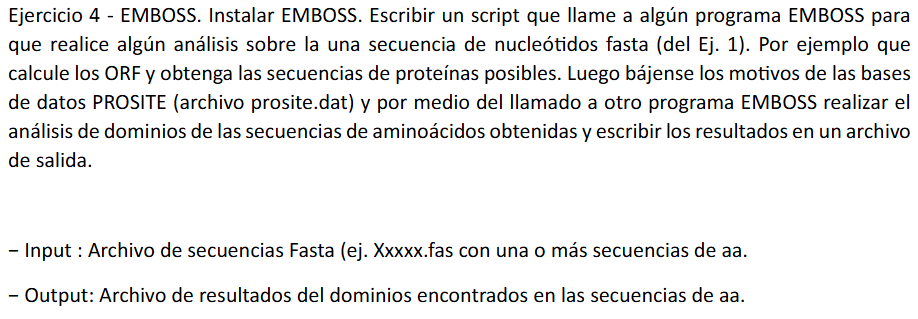

##general

In [1]:
import os
import sys
import shutil
import subprocess
!apt-get install emboss
!pip install biopython
from Bio import SeqIO

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 20.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  dialign emboss-data emboss-lib libhpdf-2.3.0 primer3
Suggested packages:
  emboss-doc emboss-test embassy clustalw ncbi-epcr
The following NEW packages will be installed:
  dialign emboss emboss-data emboss-lib libhpdf-2.3.0 primer3
0 upgraded, 6 newly installed, 0 to remove and 49 not upgraded.
Need to get 65.7 MB of archives.
After this operation, 500 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 dialign amd64 2.2.1-11 [139 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libhpdf-2.3.0 amd64 2.3.0+dfsg-1build1 [335 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 emboss-lib amd64 6.6.0+dfsg-11ubuntu1 [2,971 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 embo

In [19]:
GenBankPath = "/content/drive/MyDrive/zCarpetas importantes/Cursando/Bioinformática/opsina.gb"
GenBank = SeqIO.read(GenBankPath, "genbank")
nucleotide_sequence = str(GenBank.seq)
fasta_path = '/content/secuencia.fasta'
with open(fasta_path, 'w') as fasta_file:
    fasta_file.write(f">Opsina_sequence\n{nucleotide_sequence}\n")

In [20]:
def run_command(command):
    """Ejecuta un comando en la terminal y retorna la salida"""
    result = subprocess.run(command, shell=True, text=True, capture_output=True)
    if result.returncode != 0:
        print(f"Error ejecutando el comando: {command}\n{result.stderr}")
        return None
    return result.stdout

##ORF

In [21]:
orf_output = "orf_proteins.fasta"
print("Encontrando ORFs en la secuencia de nucleótidos...")
getorf_command = f"getorf -sequence {fasta_path} -outseq {orf_output} -find {1}"
getorf_result = run_command(getorf_command)

# Verifica si getorf se ejecutó correctamente
if getorf_result is None:
    print("Error al ejecutar getorf.")

# Verifica si se encontraron ORFs
if not os.path.exists(orf_output) or os.path.getsize(orf_output) == 0:
    print("No se encontraron ORFs en la secuencia de nucleótidos.")
else:
    print(f"ORFs encontrados y guardados en {orf_output}")
    orf_count = sum(1 for _ in SeqIO.parse(orf_output, "fasta"))
    print(f"Cantidad de ORFs encontrados: {orf_count}")

Encontrando ORFs en la secuencia de nucleótidos...
ORFs encontrados y guardados en orf_proteins.fasta
Cantidad de ORFs encontrados: 27


In [22]:
ATG_count = nucleotide_sequence.count("ATG")
stop_count = nucleotide_sequence.count("TGA")+nucleotide_sequence.count("TAA")+nucleotide_sequence.count("TAG")

print(f'La secuencia "start" aparece {ATG_count} veces en la cadena de nucleótidos.')
print(f'La secuencia "stop" aparece {stop_count} veces en la cadena de nucleótidos.')

La secuencia "start" aparece 30 veces en la cadena de nucleótidos.
La secuencia "stop" aparece 45 veces en la cadena de nucleótidos.


##Motif

In [23]:
!cp -r "/content/drive/MyDrive/zCarpetas importantes/Cursando/Bioinformática/PROSITE" "/content/PROSITE"

motifs_output = "motifs_individual_results.txt"
motifs_final_output = "motifs_final_results.txt"
prosite_path = "/content/PROSITE"

In [24]:
# Ruta del archivo original
ruta_original = '/content/orf_proteins.fasta'

# Ruta de la copia
ruta_copia = '/content/orf_copia.fasta'

# Copiar el archivo
shutil.copy(ruta_original, ruta_copia)

'/content/orf_copia.fasta'

In [25]:
def individual_orf(archivo_orfs_path):
  ruta_entrada = archivo_orfs_path
  if os.path.exists("/content/orf_individual.fasta"):
    # Si el archivo existe, eliminarlo
    os.remove("/content/orf_individual.fasta")

  ruta_salida = '/content/orf_individual.fasta'
  # Leer el archivo de entrada
  with open(ruta_entrada, 'r') as archivo_entrada:
      lineas = archivo_entrada.readlines()

  # Lista para almacenar las líneas del primer ORF
  lineas_a_borrar = []
  lineas_restantes = []

  # Variables de control
  esta_guardando_orf = False

  # Recorrer las líneas y clasificar entre las que se guardarán y las que se conservarán
  for linea in lineas:
      # Si la línea comienza con ">", indica el inicio de un ORF
      if linea.startswith('>'):
          # Si ya estábamos guardando el primer ORF, dejamos de guardar y pasamos al siguiente
          if esta_guardando_orf:
              esta_guardando_orf = False
          # Si no estábamos guardando, es el primer ORF que encontramos, así que empezamos a guardar
          elif not lineas_a_borrar:
              esta_guardando_orf = True

      # Guardar las líneas del primer ORF o del resto
      if esta_guardando_orf:
          lineas_a_borrar.append(linea)
      else:
          lineas_restantes.append(linea)

  # Guardar las líneas del primer ORF en el archivo de salida
  with open(ruta_salida, 'w') as archivo_salida:
      archivo_salida.writelines(lineas_a_borrar)

  # Sobrescribir el archivo original con las líneas restantes
  with open(ruta_entrada, 'w') as archivo_entrada:
      archivo_entrada.writelines(lineas_restantes)

In [26]:
prosextract_command = f"prosextract -prositedir {prosite_path}"
prosextract_result = run_command(prosextract_command)

In [27]:
i=1
while i<=orf_count:
  print("/n", i, "/n" )
  individual_orf('/content/orf_copia.fasta')


  # Ejecuta patmatmotifs para analizar los motivos en las secuencias de proteínas
  print(f"Analizando motivos de la secuencia {i}")
  orf_output = "/content/orf_individual.fasta"
  patmatmotifs_command = f"patmatmotifs -sequence {orf_output} -outfile {motifs_output}"
  patmatmotifs_result = run_command(patmatmotifs_command)

  # Verifica si patmatmotifs se ejecutó correctamente
  if patmatmotifs_result is None:
      print("Error al ejecutar patmatmotifs.")

  with open(motifs_output, 'r') as archivo:
      for linea in archivo:
          if 'HitCount:' in linea:
              # Extraer el valor del HitCount
              hit_count = linea.split(':')[-1].strip()
              print(f'HitCount: {hit_count}')
  if hit_count == "0":
    print("No se encontraron coincidencias.")
  else:

    # Leer el contenido del archivo fuente
    with open(motifs_output, 'r') as archivo_fuente:
        contenido = archivo_fuente.read()

    # Abrir el archivo destino en modo 'append' y agregar el contenido
    with open(motifs_final_output, 'a') as archivo_destino:
        archivo_destino.write(contenido)

    print(f'El contenido de {motifs_output} se ha agregado al final de {motifs_final_output}.')

  i=i+1

/n 1 /n
Analizando motivos de la secuencia 1
HitCount: 0
No se encontraron coincidencias.
/n 2 /n
Analizando motivos de la secuencia 2
HitCount: 0
No se encontraron coincidencias.
/n 3 /n
Analizando motivos de la secuencia 3
HitCount: 0
No se encontraron coincidencias.
/n 4 /n
Analizando motivos de la secuencia 4
HitCount: 0
No se encontraron coincidencias.
/n 5 /n
Analizando motivos de la secuencia 5
HitCount: 0
No se encontraron coincidencias.
/n 6 /n
Analizando motivos de la secuencia 6
HitCount: 0
No se encontraron coincidencias.
/n 7 /n
Analizando motivos de la secuencia 7
HitCount: 0
No se encontraron coincidencias.
/n 8 /n
Analizando motivos de la secuencia 8
HitCount: 4
El contenido de motifs_individual_results.txt se ha agregado al final de motifs_final_results.txt.
/n 9 /n
Analizando motivos de la secuencia 9
HitCount: 0
No se encontraron coincidencias.
/n 10 /n
Analizando motivos de la secuencia 10
HitCount: 0
No se encontraron coincidencias.
/n 11 /n
Analizando motivos de l

In [28]:
os.remove("/content/motifs_individual_results.txt")
os.remove("/content/orf_individual.fasta")
os.remove("/content/orf_copia.fasta")
os.remove("/content/secuencia.fasta")

FileNotFoundError: [Errno 2] No such file or directory: '/content/resultado_gc.txt'